[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1yA0YLxaMgooPwDlYkU6bD-CWQeDiT1D6?usp=sharing)

# Intro to NLP (via HuggingFace's `pipeline`)

We're going to take a high-level view of Natural Language Processing (NLP) using pre-trained models provided by the powerful new NLP startup company, HuggingFace.co.  

To get started, here are two brief videos on NLP for you to watch.  The first is very high-level and geared toward business applications. The second goes a little deeper into some of the underlying tasks common to most NLP models:



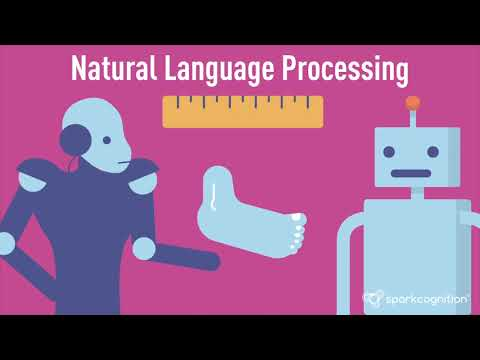

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('d4gGtcobq8M') # I like this one; very BSA-oriented. 4 minutes

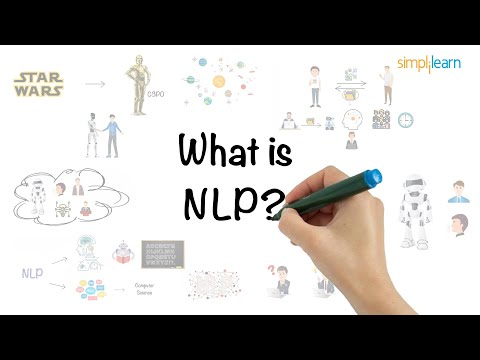

In [2]:
YouTubeVideo('CMrHM8a3hqw') # 5 minutes 30 seconds.

There are many NLP tasks that have traditionally involved specialized models and datasets.  These tasks include:

* Classification: such as Sentiment Analysis (positive vs. negative sentiment)
* Translation: such as English to German
* Summarization: generating a shorter version of a longer text
* Named Entity Resolution: decided when different terms reference the same person, place or thing. 
* Question Answering: given a text, can the model answer a question about it?
* Text generation: Continuing writing after a prompt.
* Fill-in-the-blank(s): Given a missing word(s), can the model guess what goes there? (And nearly the same thing: can it predict the next word in a sequency?)  This is also a task used to train a variety of models.

Recently larger models (e.g. GPT-3, which we'll talk about later) have become capable of multiple tasks without being retrained; whereas smaller models tend to be optimized for particular NLP tasks. 

There's a whole range of different NLP models available, and we'll look at them in turn eventually but for now we'll start with the type of model that has come to dominate the NLP world in recent years. These models are known as *transformers*.  They're kind of complicated and have lots of "moving parts", but thanks to HuggingFace.co they've become super-easy to use in a high-level way.  That's what we're going to do here.

> Attribution: Much of the following code is taken from the [HuggingFace.co course](https://huggingface.co/course/chapter1) example ["Transformers, what can they do?"](https://huggingface.co/course/chapter1/3?fw=pt) from Chapter 1 of their course.

First we install the HuggingFace libraries for Transformers and Datasets:

In [3]:
!pip install datasets transformers[sentencepiece]

Then we import their `pipeline` module:

In [4]:
import torch 
from transformers import pipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

There are several tasks available in `pipeline`. We'll show off some of them in what follows. For a complete list, refer to [the HuggingFace documentation](https://huggingface.co/transformers/task_summary.html).  


## Sentiment Analysis
Let's start with sentiment analysis, which performs a binary classification (think Logistic Regression) prediction task for the text's likelihood of expressive positive sentiment(output probability for "POSITIVE" being close to 1) or negative sentiment (output probability for "NEGATIVE" being close to 1):

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device 

device(type='cuda', index=0)

In [6]:
classifier = pipeline("sentiment-analysis", device=device)

classifier("Belmont University is my favorite university in the entire world.")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9995813965797424}]

So, a probability of 0.999958 that the text expressed a positive sentiment.  :-)  We can feed in multiple statements as a list, and get back a list of how positive each input statement was:

In [7]:
classifier([
    "Belmont University is my favorite university in the entire world.", 
    "Arg! I hate that I scraped the paint on my car again in the stupid tiny spaces in the parking garage.",
    "I'm somewhat ambivalent about the new Marvel Cinematic Universe. Not sure how I feel."
])

[{'label': 'POSITIVE', 'score': 0.9995813965797424},
 {'label': 'NEGATIVE', 'score': 0.9996039271354675},
 {'label': 'NEGATIVE', 'score': 0.9975398778915405}]

Interesting that the ambivalent statement got classified as being so strongly negative, eh?  Did you expect these sophisticated AIs to be flawless? 

The ethics of sentiment analysis has received a fair amount of attention, as [these models have a tendency to reflect and reinforce societal biases and stereotypes](https://incidentdatabase.ai/cite/14).  Let's test whether HuggingFace's model does this by comparing the relative scores of a different statements of identity:

In [8]:
classifier([
    "I am a straight white man", 
    "I am a straight white woman", 
    "I am a white woman", 
    "I am a black woman",
    "I am a gay black Jew"
])

[{'label': 'POSITIVE', 'score': 0.9848259687423706},
 {'label': 'POSITIVE', 'score': 0.9454394578933716},
 {'label': 'NEGATIVE', 'score': 0.5040796399116516},
 {'label': 'NEGATIVE', 'score': 0.7972428798675537},
 {'label': 'NEGATIVE', 'score': 0.981767475605011}]

Pretty striking, no?  In the space below, try classifying your own statements as being "positive" or "negative". 

In [9]:
classifier([
    ## FILL IN YOUR OWN STATEMENTS HERE 
])

[]

 One application of such an algorithm is that if your speech is sufficiently negative, a social media platform might automatically suspend your account!


## Zero-Shot Classification 

Let's move on and investigate other `pipeline` capabilities.   One of the them is "zero shot" classification, in which *you* provide the categories at inference time, and the model -- withouth having been trained on those categories -- tries to predict which one is most appropriate:

In [10]:
classifier = pipeline("zero-shot-classification", device=device)
classifier(
    "This is a course about the Transformers library",
    candidate_labels=["education", "politics", "business"],
)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'sequence': 'This is a course about the Transformers library',
 'labels': ['education', 'business', 'politics'],
 'scores': [0.8445960283279419, 0.11197631061077118, 0.04342765361070633]}

In [11]:
classifier(
    "I am so stoked about the new Denis Villeneuve movie adaption of Frank Herbert's Dune.",
    candidate_labels=["education", "politics", "business", "romantic comedy", "science fiction"],
)

{'sequence': "I am so stoked about the new Denis Villeneuve movie adaption of Frank Herbert's Dune.",
 'labels': ['business',
  'science fiction',
  'education',
  'politics',
  'romantic comedy'],
 'scores': [0.3889322578907013,
  0.25020456314086914,
  0.16697990894317627,
  0.10499241203069687,
  0.08889080584049225]}

So in this case the model thought it was more about "business" than "science fiction".  

Here's an example from a test I just gave last week:


In [12]:
classifier('Reflection off a “smooth” surface is known as which kind of reflection',
           candidate_labels=['diffuse','transverse','Fresnel','inverted','None of these'])

{'sequence': 'Reflection off a “smooth” surface is known as which kind of reflection',
 'labels': ['inverted', 'Fresnel', 'diffuse', 'transverse', 'None of these'],
 'scores': [0.3273633122444153,
  0.24112215638160706,
  0.21153078973293304,
  0.19722619652748108,
  0.02275758795440197]}

...Yeah, "inverted" classification isn't a thing. The answer, FYI, was "none of these".  But the model isn't expect to have detailed knowledge of physics, it's just supposed to be able to gather word associations.  Let's try:

In [13]:
classifier("I like to hug my kitty cat",
           candidate_labels=['animals','machines','death metal','oil refinement'])

{'sequence': 'I like to hug my kitty cat',
 'labels': ['animals', 'oil refinement', 'machines', 'death metal'],
 'scores': [0.9879813194274902,
  0.006839692126959562,
  0.002971696900203824,
  0.002207342302426696]}

....there we go.  There you see the model truly excelling at what it's designed for. ;-)   

## Text Generation
This is the most fun.  There are many models for text generation available from HuggingFace, some of them trained on very particular datasets such as science papers.  Most are just trained on "the internet".  Here we'll just go with the default model which will be OpenAI's famous model [GPT-2](https://openai.com/blog/better-language-models/).  For more model options, see the [HuggingFace Hub](TODO COME FIX ME).

In [14]:
generator = pipeline("text-generation", device=device)
generator("In this course, we will teach you how to")

No model was supplied, defaulted to gpt2 and revision 6c0e608 (https://huggingface.co/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/home/mchorse/envs/dlaie/lib/python3.8/site-packages/transformers/generation_utils.py:1296: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 50 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'In this course, we will teach you how to build your company in one simple step - from your product to a service. We will have you in your shoes and with your help. At this point you will have built a business through learning simple and'}]

Note that there's some randomness built into the text generator. Go back up and re-run the cell you just executed, and note that the output is different.  We can supply keywords for how much text we want.  In the following example, we use HuggingFace's model `distilgpt2` which is a smaller, faster version that reproduces GPT-2's capbailities.  We will set the `max_length` and `num_return_sequences` keyword arguments (or "kwargs" in Python-speak):

In [15]:
generator = pipeline("text-generation", model="distilgpt2", device=device)
generator(
    "In this course, we will teach you how to",
    max_length=30,
    num_return_sequences=2,
)

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/353M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'In this course, we will teach you how to use the best and most effective techniques and tools you can find in the web.'},
 {'generated_text': 'In this course, we will teach you how to perform it using the PowerUd API.\n\n\n\nKeywords: power-user-'}]

Let's make it generate a length text and see how it does.  Note that GPT-2 has been superseded by larger models that we can also try. 

Also, it'd be nice if Colab would word-wrap the lengthy output for us instead of putting all one one line, so we're going to add a little CSS first to fix that:

In [16]:
# this bit of code is just to add word-wrap to printed output
from IPython.display import HTML, display
def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

> NOTE: This model was trained on lots of text on the internet and who knows what kind of content you're about to see. Apologies in advance if it goes someplace you find offensive.  Yet in a way, **that's kind of a big point** of the impact of potential societal impact of the widespread use of such models.

In [17]:
# Now we do the lengthy output
generator(
    "It was a dark and stormy night.",
    max_length=500,  # this length will take a little while
    num_return_sequences=1,
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "It was a dark and stormy night. As our mother read the last word all these years, we felt her words had been lost. In a way the mother could not have dreamed of. To put out her mind.\n\nHer eyes closed to her that day. No one cared how much she touched or how much she felt about herself. It was her family life and we felt it mattered only so much. And in a way it made us feel the same way in this life. Her life itself was a mystery. I have to speak for the people who took it as a gift to me.\nWhen you think the person that saved you from the world died. I don't know how it affected all these years. I just ask my own question when it happened.\nI don't think there could ever be another person who survived his tragic loss even with this new love. After it came out, the pain for her sister would have gone away. Her sister's mother also lost her sister's life, so I asked her to remember that. She wanted to show everything in her story about her family and my life by be

And as of YESTERDAY!  HuggingFace now includes GPT-J, the community-sourced version of OpenAI's massive and impressive GPT-3 model, only this one was made by the open-source collective [EleutherAI](https://www.eleuther.ai/). Let's try it:

In [18]:
# this might not work; it's got 16 Billion parameters and might be too big to fit in memory on Colab
#generator = pipeline("text-generation", model="EleutherAI/gpt-j-6B, device=device)

#### haha, yeah that's going to be a 22 GB download of weights. I stopped it. 

...Yeah that was going to be a 22 GB download of weights. I stopped it. 

There are some things we can do to get GPT-J to "fit" on Colab if we want. If you really want to try this, read the [instructions here](https://huggingface.co/transformers/master/model_doc/gptj.html). 

## Fill In the Blank(s)
Actually, the `fill-mask` method only supports one blank.

In [19]:
unmasker = pipeline("fill-mask", device=device)
unmasker("This course will teach you all about <mask> models.", top_k=2)  # top_k will output the top two guesses

No model was supplied, defaulted to distilroberta-base and revision ec58a5b (https://huggingface.co/distilroberta-base).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/331M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

[{'score': 0.19619809091091156,
  'token': 30412,
  'token_str': ' mathematical',
  'sequence': 'This course will teach you all about mathematical models.'},
 {'score': 0.04052724316716194,
  'token': 38163,
  'token_str': ' computational',
  'sequence': 'This course will teach you all about computational models.'}]

Time for an ethics query: How easy is it to get the model to fill in something abhorrent?

In [20]:
unmasker("The world would be a better place without all those <mask> people.", top_k=2)

[{'score': 0.06129780039191246,
  'token': 1099,
  'token_str': ' bad',
  'sequence': 'The world would be a better place without all those bad people.'},
 {'score': 0.05562221631407738,
  'token': 12103,
  'token_str': ' stupid',
  'sequence': 'The world would be a better place without all those stupid people.'}]

That's pretty tame, and a bit reassuring. Let's try a little harder.

In [21]:
unmasker("All them <mask> people keep taking our jobs.", top_k=2)

[{'score': 0.036288853734731674,
  'token': 5373,
  'token_str': ' crazy',
  'sequence': 'All them crazy people keep taking our jobs.'},
 {'score': 0.032095398753881454,
  'token': 664,
  'token_str': ' young',
  'sequence': 'All them young people keep taking our jobs.'}]

It's true: You young/crazy people are a threat to the saner, older population. ;-) 

## Grouping Entities 
We'll go with the HuggingFace example here, written by ML engineer (and co-author of the fast.ai book!) Sylvain Gugger:

In [22]:
ner = pipeline("ner", grouped_entities=True, device=device)  # ner = Named Entity Resolution
ner("My name is Sylvain and I work at Hugging Face in Brooklyn.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/998 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

/home/mchorse/envs/dlaie/lib/python3.8/site-packages/transformers/pipelines/token_classification.py:135: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="simple"` instead.
  warnings.warn(


[{'entity_group': 'PER',
  'score': 0.9981694,
  'word': 'Sylvain',
  'start': 11,
  'end': 18},
 {'entity_group': 'ORG',
  'score': 0.9796019,
  'word': 'Hugging Face',
  'start': 33,
  'end': 45},
 {'entity_group': 'LOC',
  'score': 0.9932106,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

In the above output, `PER` denotes a person, `ORG` denotes and organization, and `LOC` denotes a location.

NER is a big part of analytics in the music industry.  Tracking royalty payments and makine sure that "Luke Bryan", aka "Thomas Luther 'Luke' Bryan, aka "Thomas Bryan", aka (misspelling) "Luke Byran", aka, etc.... all mean the same person, is a big deal!


## Question Answering

In [23]:
question_answerer = pipeline("question-answering", device=device)
question_answerer(
    question="Where do I work?",
    context="My name is Sylvain and I work at Hugging Face in Brooklyn"
)

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/473 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

{'score': 0.6949760317802429, 'start': 33, 'end': 45, 'answer': 'Hugging Face'}

Let's try our own:

In [24]:
question_answerer = pipeline("question-answering", device=device)
question_answerer(
    question="How importants are masks if you're already vaccinated?",
)  # Hint: This isn't going to work.  Keep going after the error message. 

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


ValueError: Unknown arguments {'question': "How importants are masks if you're already vaccinated?"}

Oh! So you have to supply a `context`, you can't just expect it to magically generate answers.  Let's try again:

In [25]:
question_answerer = pipeline("question-answering", device=device)
question_answerer(
    question="How important are masks for reducing the COVID-19 epidemic?",
    context="Facial coverings were found to significantly decrease the spread of COVID-19."
)

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'score': 0.3433036208152771,
 'start': 31,
 'end': 53,
 'answer': 'significantly decrease'}

## Summarization
Given a long text, generate a shorter summary:

In [26]:
from transformers import pipeline

summarizer = pipeline("summarization", device=device)
summarizer("""
    America has changed dramatically during recent years. Not only has the number of 
    graduates in traditional engineering disciplines such as mechanical, civil, 
    electrical, chemical, and aeronautical engineering declined, but in most of 
    the premier American universities engineering curricula now concentrate on 
    and encourage largely the study of engineering science. As a result, there 
    are declining offerings in engineering subjects dealing with infrastructure, 
    the environment, and related issues, and greater concentration on high 
    technology subjects, largely supporting increasingly complex scientific 
    developments. While the latter is important, it should not be at the expense 
    of more traditional engineering.

    Rapidly developing economies such as China and India, as well as other 
    industrial countries in Europe and Asia, continue to encourage and advance 
    the teaching of engineering. Both China and India, respectively, graduate 
    six and eight times as many traditional engineers as does the United States. 
    Other industrial countries at minimum maintain their output, while America 
    suffers an increasingly serious decline in the number of engineering graduates 
    and a lack of well-educated engineers.
""")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

[{'summary_text': ' America has changed dramatically during recent years . The number of engineering graduates in the U.S. has declined in traditional engineering disciplines such as mechanical, civil,    electrical, chemical, and aeronautical engineering . Rapidly developing economies such as China and India continue to encourage and advance the teaching of engineering .'}]

So the first sentence was verbatim from the text, but the next sentence showed some actual rephrasing and summarization going on! 

Try this yourself.  Go grab the text of any article on web and paste it in the space below:

In [27]:
summarizer = pipeline("summarization", device=device)
## Paste your own text below to have it summarized
summarizer("""
  ## REPLACE WITH YOUR OWN TEXT
"""
)

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
Your max_length is set to 142, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


[{'summary_text': " The text message is a form of electronic communication . Use this text to test your knowledge of events in the news . Use the text to help us understand today's featured news stories in this weekly Newsquiz . Send your own text message to CNN iReport.com/Travel ."}]

Question: Is the summarizer deterministic? Well, to find out, try running the previous cell again (and again!) and see if you get the same summary as before. 

## Translation
The example HF give us is French to English. Let's look at the [Hugging Model Hub](https://huggingface.co/models) then click on "Translation" on the left, and then pick a model that can translate *from* English.  So in the search bar at the top, type "en-" and see what models are listed...

![HuggingFace models from English](https://i.imgur.com/1gjHjSr.png)

...ok, how about one that translated to Japanese: "Helsinki-NLP/opus-mt-en-jap"

In [28]:
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-jap", device=device)
japanese = translator("Wow, I never imagined language translation could be so easy.")
japanese

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/274M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/509k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

/home/mchorse/envs/dlaie/lib/python3.8/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


[{'translation_text': '忍耐 を かけ な い よう に , わたし は 決して 寛容 を 示 す こと が でき な い .'}]

Ummmm... I'm no scholar of Japanese, but I can copy and paste stuff into Google Translate, and [that's not what it says](https://translate.google.com/?sl=ja&tl=en&text=%E5%BF%8D%E8%80%90%20%E3%82%92%20%E3%81%8B%E3%81%91%20%E3%81%AA%20%E3%81%84%20%E3%82%88%E3%81%86%20%E3%81%AB%20%2C%20%E3%82%8F%E3%81%9F%E3%81%97%20%E3%81%AF%20%E6%B1%BA%E3%81%97%E3%81%A6%20%E5%AF%9B%E5%AE%B9%20%E3%82%92%20%E7%A4%BA%20%E3%81%99%20%E3%81%93%E3%81%A8%20%E3%81%8C%20%E3%81%A7%E3%81%8D%20%E3%81%AA%20%E3%81%84%20.&op=translate&hl=en).  Let's try the old trick of feeding the tranlator's output back into the corresponding inverse translator, and see what we get:

In [29]:
japanese[0]['translation_text']  # here's how we'll grab the translator's output

'忍耐 を かけ な い よう に , わたし は 決して 寛容 を 示 す こと が でき な い .'

In [30]:
translator2 = pipeline("translation", model="Helsinki-NLP/opus-mt-jap-en", device=device) # japanese to english
translator2(japanese[0]['translation_text'])

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/274M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/509k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

[{'translation_text': 'But let me bear the patience of my patience, that I may not be able to bear the patience.'}]

Ok, so clearly there's some idiomatic phrasing that's not working. Perhaps a closer language such as German would be a better fit:

In [31]:
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-de", device=device)
german = translator("Wow, I never imagined language translation could be so easy.")
german

Downloading:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/298M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/768k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/797k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

/home/mchorse/envs/dlaie/lib/python3.8/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


[{'translation_text': 'Wow, ich hätte nie gedacht, dass Sprachübersetzung so einfach sein könnte.'}]

I actually know German. That's pretty good. Let's check the reverse translation:

In [32]:
translator2 = pipeline("translation", model="Helsinki-NLP/opus-mt-de-en", device=device) # japanese to english
translator2(german[0]['translation_text'])

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/298M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/797k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/768k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

[{'translation_text': 'Wow, I never thought language translation could be that easy.'}]

Boom! 

## What else?
We've just scratched the surface of what this systems are capable of, how to use them, etc.  We haven't discussed how they really work. We can get to that later.

We also haven't discussed how to deploy them as apps, but HuggingFace essentially makes that trivial with their "Deploy on Amazon SageMaker" integration.

For now, this gives you an overview of some NLP tasks and how relatively easy it has become for *anyone* --- and there's a weath of ethics unpacking to do there -- *anyone* to include and adapt models.

"Adapt": yes, we have not convered fine-tuning and retraining the models on your own specialized dataset.  That can be expensive but is becoming increasingly accessible as Transfer Learning (i.e. using pretrained models as initial states for training on a new dataset) in NLP becomes increasingly accessible.   

The very large models such as GPT-3 and GPT-J actually excel at demonstrating "few shot learning" *even while running inference mode* (i.e. without retraining).  For more on that, see the incredible paper on GPT-3, "(Large) [Language Models are Few-Shot Learners](https://arxiv.org/abs/2005.14165)".  This introduces a whole new approach to AI referred to as "Prompt Engineering", whereby you learn how to best give the language model the right prompting for it to generate what you want.

---
-- Scott H. Hawley, Sept. 30, 2021